In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
#build vocabulary of characters  and mappings to/from integers

chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3

def build_dataset(words):

  X, Y = [], []
  for w in words:
    #print(w)
    context = [0]* block_size


    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context),'--->', itos[ix])
      context = context[1:]+[ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


# Xtr is just a tensor containing a list of every block sized context array. e.g. if block size 3, list of every 3 long array of numbers
#Ytr is a tensor containing an array of numbers indexing each letter starting from the second one. Each number corresponds to the context array
#of numbers in Xtr at same position
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])






torch.Size([182462, 3]) torch.Size([182462])
torch.Size([22707, 3]) torch.Size([22707])
torch.Size([22977, 3]) torch.Size([22977])


In [5]:
#building MLP
n_embd = 10 #dimensionality of character embedding vectors
n_hidden = 200 #no. of neurons in hidden layer of MLP

C = torch.rand((vocab_size,n_embd))
W1 = torch.randn((n_embd*block_size,n_hidden)) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden) * 0.01  #b1 redundant because of batchnormalisation bias
W2 = torch.randn((n_hidden,vocab_size)) *0.1
b2 = torch.randn(vocab_size) * 0.1


bngain = torch.randn((1, n_hidden))*0.1+1.0
bnbias = torch.randn((1, n_hidden))*0.1  #non-zero to unmask errors in calculating gradients w.r.t biases.



parameters = [C, W1 , W2, b2, bngain, bnbias]


for p in parameters:
  p.requires_grad = True



In [8]:
# optimisation

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


max_steps = 200000
batch_size =32
lossi = []

for i in range(max_steps):

  #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    # ix is an array,  batch size integers long with each number going upto the number of context arrays in Xtr - a large number
    # Xtr[ix] is a list of context arrays at the random 32 indices of ix
    Xb, Yb = Xtr[ix], Ytr[ix]
  # forward pass

    # then emb is a list of list of arrays of the embedding vectors of each character in each context array.
    emb = C[Xb]   #[batch_size, block_size, n_embd]
    #-1 means infer dimension automatically, i.e. when you multiply by W1 - so this dimension becomes no. of rows of W1, i.e. n_embd*block_size
    # here the separate embeddings for each character in say context of [emm] become one big 30 number long embedding
    embcat = emb.view(emb.shape[0], -1)  #keeps size of first dimension, here the batch_size

    hpreact = embcat @ W1 #+ b1   gets cancelled out when you minus the mean.


    #batchnorm layer ---------------- this idea came out in 2015, allowed for better training of deeper nets which we see today.
    bnmeani = hpreact.mean(0, keepdim=True)

    bnstdi = hpreact.std(0, keepdim=True)

    #the .mean is a function of all the examples within a batch so has to be optimised with respect to all of them. -this is slow
    #and produces irregularities as the mean can change a lot between batches if batch sie is small
    hpreact = bngain*(hpreact-bnmeani)/bnstdi  + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001* bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    #-----------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)

    #loss = -prob[torch.arange(32), Y].log().mean()

    loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()



  #update
  #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

  #track stats
    if i % 10000 ==0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')


    lossi.append(loss.log10().item())

print(loss.item())


      0/ 200000:2.0967


  10000/ 200000:1.8285
  20000/ 200000:2.2081
  30000/ 200000:2.4491
  40000/ 200000:2.2982
  50000/ 200000:1.8316
  60000/ 200000:1.9654
  70000/ 200000:2.4741
  80000/ 200000:2.0684
  90000/ 200000:1.8060
 100000/ 200000:2.3943
 110000/ 200000:2.1593
 120000/ 200000:2.0192
 130000/ 200000:2.0117
 140000/ 200000:2.0592
 150000/ 200000:2.1490
 160000/ 200000:2.3110
 170000/ 200000:1.8463
 180000/ 200000:2.1476
 190000/ 200000:1.9116
2.1246371269226074


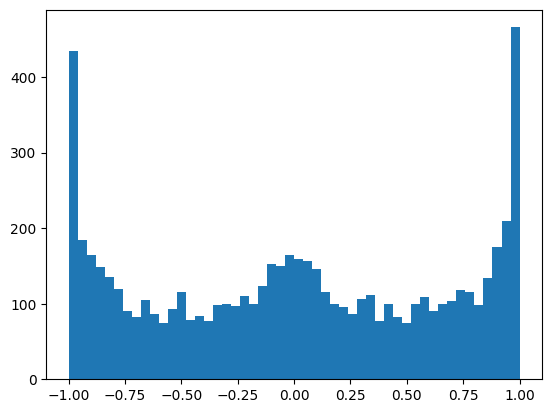

In [10]:
plt.hist(h.view(-1).tolist(), 50);


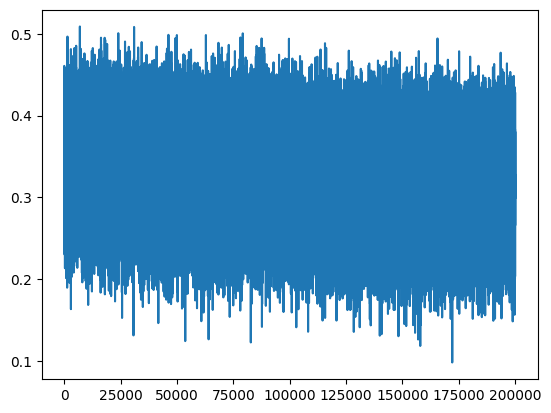

In [11]:
plt.plot(lossi)

In [12]:
#calibrate the batch norm at the end of training
with torch.no_grad():
    #pass training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)




In [13]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)  #keeps size of first dimension, here the batch_size
    hpreact = embcat @ W1
    hpreact = bngain*(hpreact-bnmean)/bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')




train 2.064741849899292
val 2.110809326171875


In [14]:
#sampling

for _ in range(20):
  out = []
  context = [0]* block_size
  while True:
    emb=C[torch.tensor([context])]
    h = torch.tanh(emb.view(1,-1)@ W1 +b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))


prephipkinstonfaten.
hddy.
phirvelipmoiliezmi.
quinfleyssstwu.
jemnullnakieqursifzen.
philandrymagtllezix.
phi.
prynnliygrummirquesiemorg.
ziliquyto.
phlokfmy.
hivaniyahvingitleyxyass.
phirvelmyzon.
prewton.
ppylin.
plyn.
wennaetanylu.
ppwilsy.
elmawen.
fbrtnkwiysydntwullwextynet.
ppfenlulifsphiliatz.


In [ ]:
#SUMMARY-----

In [ ]:
#a deeper net

class Linear:

    def __init__(self,fan_in, fan_out, bias=True):
        #to keep area of normal distribution 1 during mulplication by W, divide by fan_in**0.5
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else none

    def __call__(self, x):
        self.out = x@ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar =  self.running_var

        xhat = (x-xmean) / torch.sqrt(xvar +self.eps)  #normalise to unit variance
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embd = 10
n_hidden = 100


C = torch.randn((vocab_size, n_embd))
#using non linear tanh functions allow for greater range of non linear functions to be calculated than if just linear W functions were used.
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden           , n_hidden), BatchNorm1d(n_hidden), Tanh(),
     Linear(n_hidden           , n_hidden), BatchNorm1d(n_hidden), Tanh(),
     Linear(n_hidden           , n_hidden), BatchNorm1d(n_hidden), Tanh(),
     Linear(n_hidden           , n_hidden), BatchNorm1d(n_hidden), Tanh(),
     Linear(n_hidden           , vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    #last layer, make less confident to make activations closer to zero an uniform to have lower loss
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    #all other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):   # to maintain area of normal distrbution when tanh is applied
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True





47551


In [ ]:
# optimisation

max_steps = 200000
batch_size =32
lossi = []
ud = []


for i in range(max_steps):

  #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
  # forward pass

   #forward pass
    emb = C[Xb]   #[batch_size, block_size, n_embd]
    x = emb.view(emb.shape[0], -1)  #keeps size of first dimension, here the batch_size
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward_pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()




  #update

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

  #track stats
    if i % 10000 ==0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i>1000:
        break
print(loss.item())


      0/ 200000:3.2967
2.2676963806152344


layer 2 (      Tanh): mean-0.01, std 0.63, saturated: 2.50%
layer 5 (      Tanh): mean+0.00, std 0.64, saturated: 2.38%
layer 8 (      Tanh): mean+0.00, std 0.64, saturated: 2.62%
layer 11 (      Tanh): mean+0.00, std 0.64, saturated: 2.34%
layer 14 (      Tanh): mean-0.00, std 0.65, saturated: 1.91%


/tmp/ipython-input-2737422864.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('layer %d (%10s): mean%+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

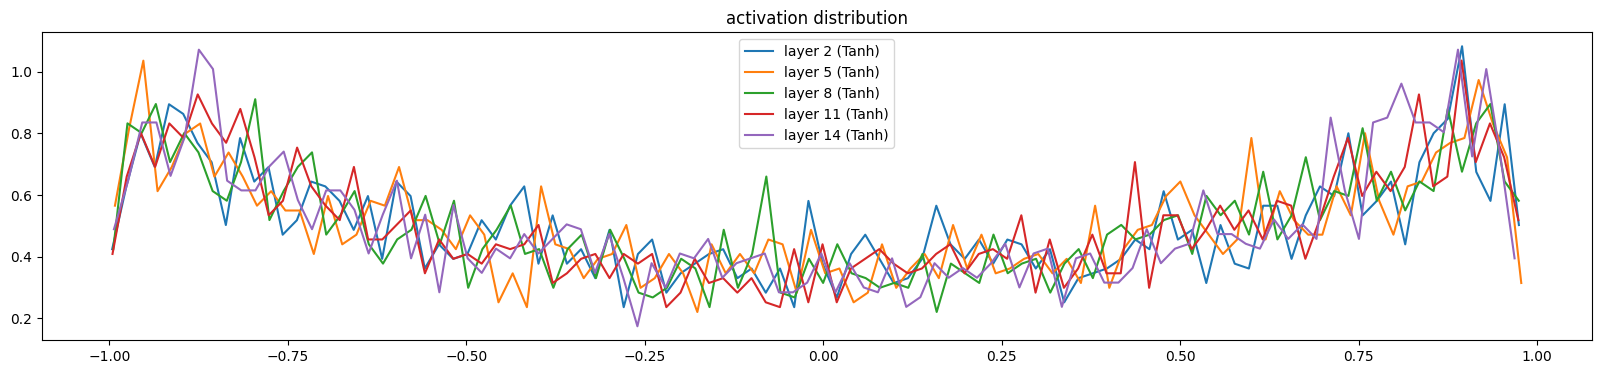

In [ ]:
#visualise histograms
plt.figure(figsize = (20, 4))
legends =[]
for i, layer in enumerate(layers[:-1]):   #excludes output softmax layer
    if isinstance(layer, Tanh):

        t=layer.out
        print('layer %d (%10s): mean%+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density = True) # t is each output value - lot so graph looks smooth. density=True means area under histogram sums to one, hx is dens value(height of each bin), hy is edges of each bin
        plt.plot(hx[:-1].detach(), hy.detach()) #hx[:-1] gives left edges of bins, .detach() means dont track the gradient - gives smooth graph
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')




layer 2 (      Tanh): mean-0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean-0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean-0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean-0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean+0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

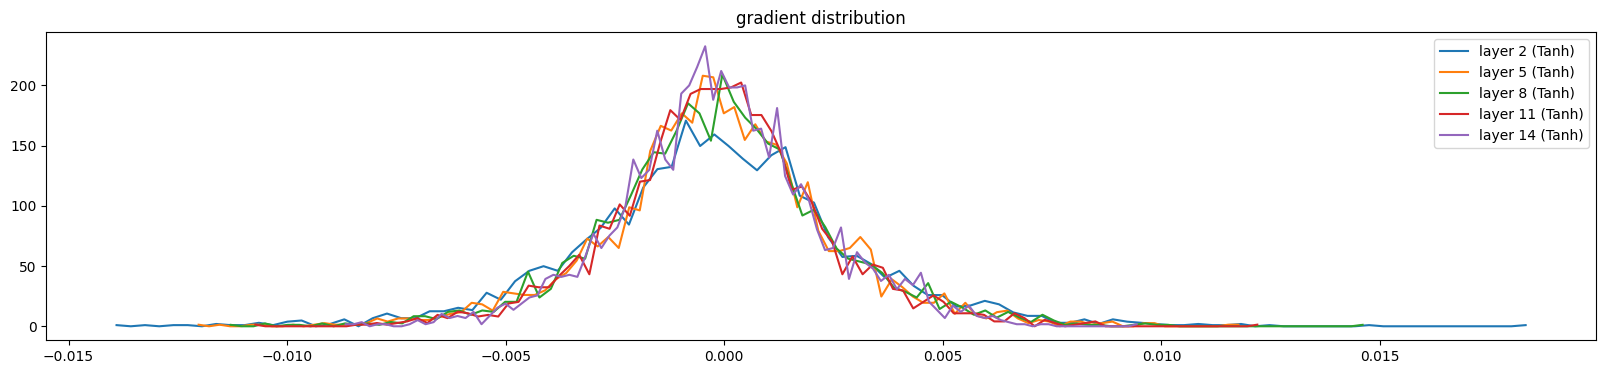

In [ ]:
#visualise histograms
plt.figure(figsize = (20, 4))
legends =[]
for i, layer in enumerate(layers[:-1]):   #excludes output softmax layer
    if isinstance(layer, Tanh):

        t=layer.out.grad
        print('layer %d (%10s): mean%+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density = True) # t is each network output value - lot so graph looks smooth. density=True means area under histogram sums to one, hx is bin edges, hy is the density values  - histogram gives activation values on x axis and no of activation values in that range on y axis
        plt.plot(hx[:-1].detach(), hy.detach()) #hx[:-1] gives left edges of bins, .detach() means dont track the gradient - gives smooth graph, plots activations against their no.
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')




weight   (27, 10) | mean+0.000000 | std 8.726740e-03  | grad:data ratio 8.249211e-03
weight  (30, 100) | mean+0.000079 | std 7.582586e-03  | grad:data ratio 2.525194e-02
weight (100, 100) | mean+0.000049 | std 6.120658e-03  | grad:data ratio 3.655997e-02
weight (100, 100) | mean-0.000057 | std 5.556311e-03  | grad:data ratio 3.328390e-02
weight (100, 100) | mean+0.000050 | std 4.777544e-03  | grad:data ratio 2.823612e-02
weight (100, 100) | mean+0.000075 | std 4.671752e-03  | grad:data ratio 2.814643e-02
weight  (100, 27) | mean+0.000092 | std 9.121955e-03  | grad:data ratio 5.433254e-02


Text(0.5, 1.0, 'weights gradient distribution')

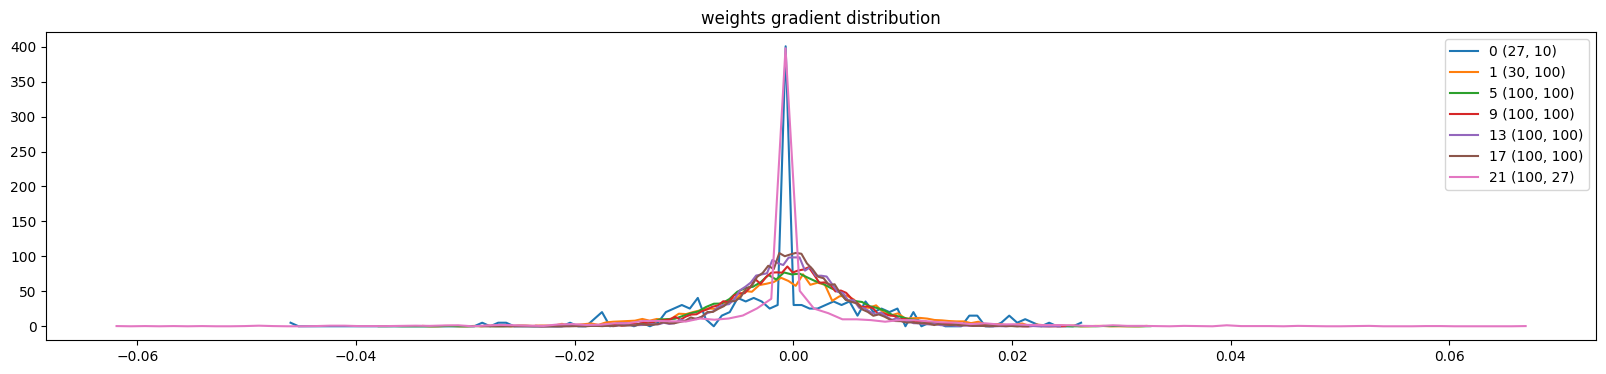

In [ ]:
#visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    t=p.grad
    if p.ndim == 2:
        print('weight %10s | mean%+f | std %e  | grad:data ratio %e' % (tuple(p.shape), t.mean(),t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution')


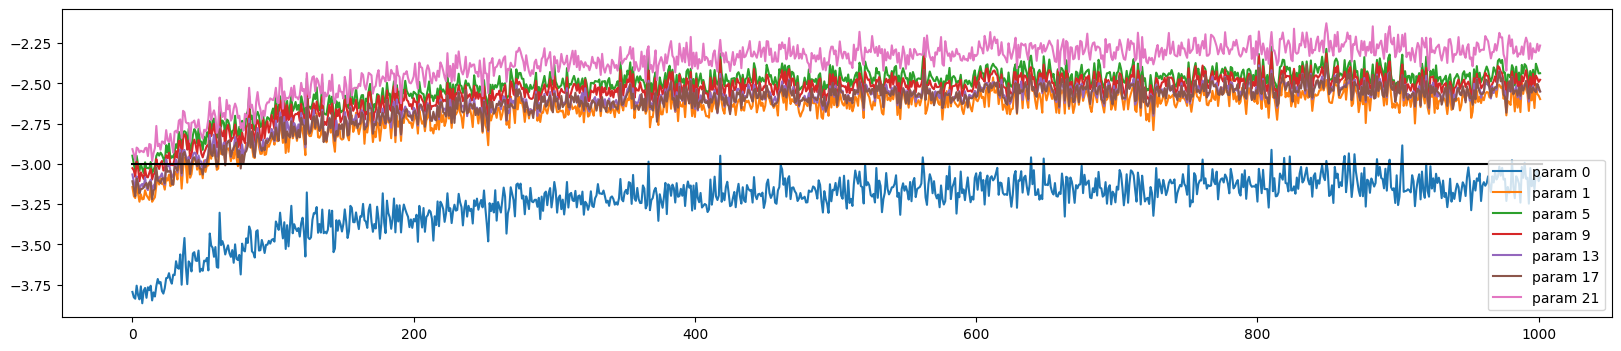

In [ ]:
#visualise histograms
#this graph says what happens to updata/data for each weight parameter group as we loop through all the training data. I think you'd want it to decrease? smaller update- less likely to overstep in backprop?
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    t=p.grad
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])  #ud is 2-d array, [max_steps, no_ of parameters],len(ud) gives max steps,so j loops through the same paramter for different trialdata, i loops through each parameter for each trial data
        legends.append(f'param %d' % i)
plt.legend(legends);
plt.plot([0, len(ud)],[-3,-3],'k')  #It draws a black diagonal line from the point (0, -3) to (len(ud), -3) on the current plot.
#the ratios should be 1e-3, indicate on plot

